In [2]:
import numpy as np
import math
import matplotlib.pylab as plt
from astropy.io import fits
import os
from PIL import Image

In [3]:
"""
Intialization of the values

"""

dir="C:/Users/hp/Desktop/FITS_files_XOS2_f437" #path to directory containing all FITS files
height=500
width=height*2

# Dont change these parameters
min_pixel_color=50 #default 50. better to not change this value
max_difference=40 #default 40 degrees. max angle difference between Mars subsolar long and SC long
delta_long=60 #default 60 degrees. max long difference between Mars subsolar long and pixel long
delta_lat=80 #default 80 degrees. max lat difference between Mars subsolar lat and pixel lat
delta_added_latlon=10 #default 10 degrees. added latlon range based on sun distance from Mars


In [4]:
"""
    Code to find which ranges of lat and long is bright for each disk image.
"""

def longvalue(value):
    if(value>180):
        return value-360
    if(value<-180):
        return value+360
    return value

def checklong(long,long_bounds):
    if(long_bounds[0]<long_bounds[1]):
        return (long>long_bounds[0] and long<long_bounds[1])
    return (long>long_bounds[0] or long<long_bounds[1])

def checklat(lat,lat_bounds):
    if(lat_bounds[1]>90):
        return (lat>lat_bounds[0])
    if (lat_bounds[0]<-90):
        return (lat<lat_bounds[1])
    return (lat>lat_bounds[0] and lat<lat_bounds[1])

def good_pixel(coord,long_bounds,lat_bounds):
    if(checklong(coord[0],long_bounds) and checklat(coord[1],lat_bounds)):
        return True
    return False


def get_clean_pixel(hdul):
    hdr=hdul[0].header
    #important parameters
    color_filter= hdr['FILTER']
    subsolar_long= hdr['SSOLLON']
    subsolar_lat= hdr['SSOLLAT']
    distance_from_sun= hdr['SOLDIST']
    sc_long= hdr['SSCLON']
    sc_lat= hdr['SSCLAT']
    #data
    sci = hdul[1].data
    lat = hdul['LAT'].data
    long = hdul['LONG'].data
    if(abs(subsolar_long-sc_long)>max_difference and abs(subsolar_long-sc_long)<(360-max_difference)):
        return color_filter,[[0,0,0]]
    
    distance_ratio=(1.66-distance_from_sun)/(1.66-1.38)
    modified_delta_long=delta_long+delta_added_latlon*distance_ratio
    modified_delta_lat=delta_long+delta_added_latlon*distance_ratio
    
    long_bounds=[longvalue(subsolar_long-modified_delta_long), longvalue(subsolar_long+modified_delta_long)]
    lat_bounds=[subsolar_lat-modified_delta_lat, subsolar_lat+modified_delta_lat]

    #delta_mask=5 #dgrees
    #long_mask=[longvalue(sc_long+90+delta_mask),longvalue(sc_long+90-delta_mask)]
    
    coords=np.dstack((long,lat,sci))
    flatten_coords = [val for sublist in coords for val in sublist] # from 3D to 2D matrix
    
    clean_pixels_array=[arr for arr in flatten_coords if(arr[2]>min_pixel_color and good_pixel(arr,long_bounds,lat_bounds))]
    
    return color_filter, clean_pixels_array


In [5]:
""" Loading the data from the FITS files"""
fits_image_filename = os.listdir(dir)
disk_images=[fits.open(os.path.join(dir, fit)) for fit in fits_image_filename]

In [6]:
""" Create the good pixels array [[lon,lat,sci],....] for each filter"""

r_arr,g_arr,b_arr=[[0,0,0]],[[0,0,0]],[[0,0,0]]

for hdul in disk_images:
    color_filter,arr=get_clean_pixel(hdul)
    if(len(arr)!=1):
        if color_filter=='F437':
            b_arr+=arr
        elif color_filter=='F546':
            g_arr+=arr
        elif color_filter=='F635':
            r_arr+=arr



In [7]:
def values_to_rgb(arr):
    arr=np.array(arr)
    lon,lat,color= arr.T
    max_pixel_color= max(color)
    color=(color-min_pixel_color)/(max_pixel_color-min_pixel_color)*255
    arr=np.stack([lon,lat,color],-1)
    return arr[1:] # [1:] to remove the first pixel [0,0,0] from the intialization

r_arr=values_to_rgb(r_arr)
g_arr=values_to_rgb(g_arr)
b_arr=values_to_rgb(b_arr)

In [9]:
method='Averaging' # Averaging - Heighest


def get_matrix(arr):
    matrix=np.zeros((width+1,height+1))
    num_pixels=np.ones_like(matrix)

    for pixel in arr:
        i=int(np.round_((pixel[0]+180)*width/360))
        j=int(np.round_((pixel[1]+90)*height/180))
        j=height-j
        
        if (method=='Averaging'):
            num=num_pixels[i][j]
            matrix[i][j]= (matrix[i][j]*num+pixel[2])/(num+1)
            #print(map_image[i][j])
            num_pixels[i][j]+=1
            
        if(method=='Heighest'):
            if(pixel[2]>matrix[i][j]):
                matrix[i][j]=pixel[2]
    return matrix

r_matrix=get_matrix(r_arr)
g_matrix=get_matrix(g_arr)
b_matrix=get_matrix(b_arr)



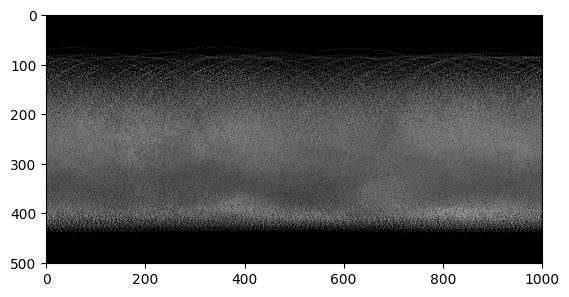

In [10]:
fig = plt.figure()
plt.imshow(r_matrix.T, cmap='gray')#,interpolation='spline16')
plt.imshow(g_matrix.T, cmap='gray')#,interpolation='spline16')
plt.imshow(b_matrix.T, cmap='gray')#,interpolation='spline16')

In [14]:
numpy_image=np.dstack((r_matrix,g_matrix,b_matrix))

#PIL_image = Image.fromarray(np.uint8(numpy_image)).convert('RGB')

PIL_image = Image.fromarray(numpy_image.astype('uint8'), 'RGB')

PIL_image.show()
PIL_image.save('Mars_Full_Map.png')